In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import voxelmorph as vxm

import numpy as np
import tensorflow as tf

from tensorflow import keras

from model import get_model

from data_generator import train_generator, test_generator

import matplotlib.pyplot as plt

# =============================================================================
# Build the backbone model
# =============================================================================

moving_image_shape = (64, 64, 64, 1)
fixed_image_shape = (64, 64, 64, 1)

model = get_model(moving_image_shape, fixed_image_shape, with_label_inputs=False)

print('\nBackbone model inputs and outputs:')

print('    input shape: ', ', '.join([str(t.shape) for t in model.inputs]))
print('    output shape:', ', '.join([str(t.shape) for t in model.outputs]))

# =============================================================================
# Build the registration network
# =============================================================================

# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the moving image
moving_image = model.input[0]

# extract ddf
ddf = model.output

# warp the moving image with the transformer using network-predicted ddf
moved_image = spatial_transformer([moving_image, ddf])

outputs = [moved_image, ddf]

registration_model = keras.Model(inputs=model.inputs, outputs=outputs)

print('\nRegistration network inputs and outputs:')

print('    input shape: ', ', '.join([str(t.shape) for t in registration_model.inputs]))
print('    output shape:', ', '.join([str(t.shape) for t in registration_model.outputs]))

losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.05
loss_weights = [1, lambda_param]

registration_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# =============================================================================
# Training loop
# =============================================================================

f_path = r'/workspace/reg_challenge/dataset/train'

val_path = r'/workspace/reg_challenge/dataset/val'

model_save_path = r'voxelmorph_model_checkpoints_loss_'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

batch_size = 32

train_gen = train_generator(f_path, batch_size, moving_image_shape, fixed_image_shape, with_label_inputs=False)

num_trials = 1024

val_dice = []

# registration_model = keras.models.load_model(os.path.join(model_save_path, 'registration_model_trial_328'), custom_objects={'loss': [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss], 'loss_weights': [1, lambda_param]})


Backbone model inputs and outputs:
    input shape:  (None, 64, 64, 64, 1), (None, 64, 64, 64, 1)
    output shape: (None, 64, 64, 64, 3)

Registration network inputs and outputs:
    input shape:  (None, 64, 64, 64, 1), (None, 64, 64, 64, 1)
    output shape: (None, 64, 64, 64, 1), (None, 64, 64, 64, 3)


In [3]:
registration_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 64,   0           ['input_1[0][0]',                
                                2)                                'input_2[0][0]']          

In [5]:
from tensorflow.keras import layers
from tensorflow import keras

moving_image_shape = (64, 64, 64, 1)
fixed_image_shape = (64, 64, 64, 1)
with_label_inputs=True

input_moving_image = keras.Input(moving_image_shape)
input_fixed_image = keras.Input(fixed_image_shape)

if with_label_inputs:
    input_moving_label = keras.Input(moving_image_shape)
    input_fixed_label = keras.Input(fixed_image_shape)

concatenate_layer = layers.Concatenate(axis=-1)([input_moving_image, input_fixed_image])

In [6]:
print(concatenate_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64, 2), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


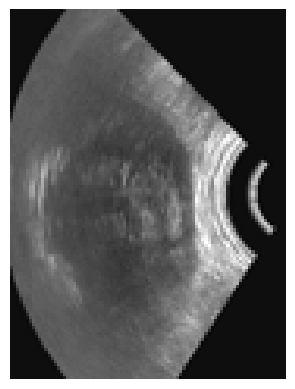

In [30]:
import nibabel as nib
from PIL import Image
import glob

# NIfTI 파일 경로
img_list = '/path/to/input.nii'

# PNG 파일 경로
png_path = '/path/to/output.png'

for nii_path in img_list :
    # NIfTI 파일 불러오기
    nii_image = nib.load(nii_path)
    # 이미지 배열 추출
    image_array = nii_image.get_fdata()
    # 이미지 배열을 0-255 범위로 정규화
    normalized_image = (image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255
    # 이미지 배열을 uint8 데이터 타입으로 변환
    image_uint8 = normalized_image.astype('uint8')
    # 이미지 객체 생성
    image = Image.fromarray(image_uint8)
    # 이미지를 PNG 파일로 저장
    image.save(png_path)